In [17]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import edward as ed
import numpy as np
import tensorflow as tf
from edward.models import Beta,Bernoulli,RelaxedBernoulli, MultivariateNormalDiag, Dirichlet, OneHotCategorical,Normal,MultivariateNormalFullCovariance,Mixture,ParamMixture
from edward.models.random_variables import TransformedDistribution
from scipy.stats import norm,lognorm
import math
import time
from build_dataset import build_dataset_1dim_gmm
from distributions import logNormal

In [18]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

In [19]:
def hist_point(N,x_data):
    hist = [[] for i in range(80)]
    point = np.array([[0.0]*N]*2,dtype=np.float32)
    width = 0.25
    height = 1.0/(width*N)
    for n in range(N):
        d=x_data[n]
        h=int((d-5.0)/width)
        hist[h].append(n)
        point[0][n]=5.0+h*width
        point[1][n]=(len(hist[h])-1)*height
    return point,width,height

In [23]:
def gmm_bbvi_1dim_gmm_z_mu_sigma(N,x_data,n_iter,lambda_m0_init=10.0,lambda_m1_init=20.0):
    start = time.time()
    ds = tf.contrib.distributions
    #generative model 
    pi = 0.5
    mu0 = Normal(loc=tf.constant(10.0),scale=tf.constant(0.5))
    mu1 = Normal(loc=tf.constant(20.0),scale=tf.constant(0.5))
    sigma0 = logNormal(loc=tf.constant(1.0),scale=tf.constant(0.5))
    sigma1 = logNormal(loc=tf.constant(1.0),scale=tf.constant(0.5))
    z = [Bernoulli(probs = pi, dtype = tf.float32) for n in range(N)]
    x = [Normal(loc=mu0*(1.0-z[n])+mu1*z[n],
                          scale=sigma0*(1.0-z[n])+sigma1*z[n]) for n in range(N)]
    print("generative model")
    #variational model
    lambda_m0= tf.Variable(lambda_m0_init)
    lambda_m1= tf.Variable(lambda_m1_init)
    lambda_s0= tf.nn.softplus(tf.Variable(1.5))
    lambda_s1= tf.nn.softplus(tf.Variable(1.5))
    qmu0 = Normal(loc=lambda_m0, scale=lambda_s0) 
    qmu1= Normal(loc=lambda_m1, scale=lambda_s1) 

    lambda_a0= tf.Variable(0.01)
    lambda_a1= tf.Variable(0.01)
    lambda_b0= tf.nn.softplus(tf.Variable(0.0))
    lambda_b1= tf.nn.softplus(tf.Variable(0.0))
    qsigma0 = logNormal(loc=lambda_a0,scale=lambda_b0)
    qsigma1 = logNormal(loc=lambda_a1,scale=lambda_b1)
    temperature = tf.constant(0.66)
    y = [tf.Variable(0.0) for n in range(N)]
    lambda_z = [tf.nn.sigmoid(y[n]) for n in range(N)]
    qz = [RelaxedBernoulli(temperature,probs = lambda_z[n]) for n in range(N)]
    print("variational model")
    latent_vars = {z[n]:qz[n] for n in range(N)}
    latent_vars[mu0]=qmu0
    latent_vars[mu1]=qmu1
    latent_vars[sigma0]=qsigma0
    latent_vars[sigma1]=qsigma1

    data = {x[n]:x_data[n] for n in range(N)}

    inference = ed.KLqp(latent_vars=latent_vars,data=data)
    inference.initialize(n_iter=n_iter,n_samples=1)
    print("inference")
    print(time.time()-start)
    sess=ed.get_session()
    tf.global_variables_initializer().run()
    loss = []
    variational_parameter = []
    variational_parameter.append(sess.run([lambda_m0, lambda_s0, lambda_m1, lambda_s1, lambda_z,lambda_a0,lambda_b0,lambda_a1,lambda_b1]))
    for _ in range(inference.n_iter):
            info_dict = inference.update()
            loss.append(info_dict['loss'])
            variational_parameter.append(sess.run([lambda_m0, lambda_s0, lambda_m1, lambda_s1, lambda_z,lambda_a0,lambda_b0,lambda_a1,lambda_b1]))
    print(time.time()-start)          
    return loss,variational_parameter

<IPython.core.display.Javascript object>


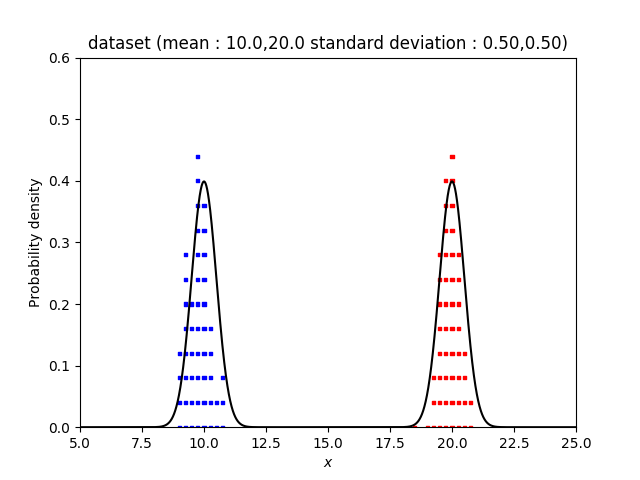

In [24]:
%matplotlib nbagg
N=100
mean_true = np.array([10.0,20.0])
std_true = np.array([0.5,0.5])
pi_true = np.array([0.5,0.5])

x_data,label =build_dataset_1dim_gmm(N,mean_true,std_true,pi_true)
point,width,height = hist_point(N,x_data)

area = [[5.0]*N]
grid = np.linspace(start=5.0,stop=25.0,num=10000)
plt.title("dataset (mean : {0:.1f},".format(mean_true[0]) +"{0:.1f} ".format(mean_true[1])+"standard deviation : {0:.2f},".format(std_true[0])+"{0:.2f})".format(std_true[1]))
plt.xlabel("$x$")
plt.ylabel("Probability density")
plt.xlim(5.0,25.0)
plt.ylim(0.0,0.6)
plt.plot(grid,norm.pdf(x=grid,loc=mean_true[0], scale=std_true[0])*pi_true[0]+norm.pdf(x=grid,loc=mean_true[1], scale=std_true[1])*pi_true[1],color="black")
color =[]
for t,p in enumerate(label):
    color.append([p,0.0,1.0-p])
plt.scatter(point[0],point[1],s=area,c=color,marker='s')
plt.show()
#plt.savefig("dataset_ex3.png")


In [25]:
loss, variational_parameter = gmm_bbvi_1dim_gmm_z_mu_sigma(N,x_data,n_iter=2000,lambda_m0_init=10.0,lambda_m1_init=20.0 )

generative model
variational model
inference
238.45680499076843
352.0457808971405


In [26]:
for t,vp in enumerate(variational_parameter):
    print(t,vp[0],vp[2],vp[5],vp[7])

0 10.0 20.0 0.01 0.01
1 10.1 19.9 0.11 0.11
2 10.1847 19.8152 0.19576 0.194998
3 10.2494 19.7307 0.281724 0.286637
4 10.3079 19.6579 0.360363 0.370332
5 10.3548 19.5827 0.431683 0.451334
6 10.4001 19.501 0.501753 0.535299
7 10.4455 19.415 0.571678 0.621107
8 10.4869 19.3416 0.639805 0.702857
9 10.5257 19.2668 0.705097 0.78231
10 10.5613 19.2012 0.765413 0.853954
11 10.5935 19.1357 0.822188 0.92215
12 10.6239 19.0784 0.874821 0.98483
13 10.6537 19.0259 0.924438 1.04462
14 10.6817 18.9791 0.969361 1.09912
15 10.7181 18.9392 1.01816 1.15395
16 10.7562 18.9047 1.06382 1.20363
17 10.7908 18.8738 1.1058 1.24896
18 10.8351 18.851 1.15292 1.2947
19 10.8771 18.8321 1.19817 1.33737
20 10.9133 18.817 1.23922 1.37538
21 10.9479 18.8116 1.28073 1.4143
22 10.9791 18.8071 1.31839 1.45142
23 11.0061 18.8027 1.35291 1.48471
24 11.0292 18.7983 1.38413 1.51496
25 11.0515 18.7953 1.41315 1.54387
26 11.0716 18.7943 1.43935 1.56964
27 11.0886 18.796 1.46349 1.59319
28 11.1034 18.7991 1.48565 1.61458
29 11.1

356 10.5553 19.3826 1.61481 1.61364
357 10.5579 19.3836 1.61612 1.61431
358 10.5584 19.384 1.61671 1.61417
359 10.5585 19.3816 1.61724 1.61417
360 10.5583 19.3802 1.61684 1.61331
361 10.5614 19.381 1.61796 1.61302
362 10.5647 19.3809 1.62007 1.61289
363 10.5668 19.3799 1.62232 1.6126
364 10.568 19.3785 1.62399 1.61213
365 10.569 19.3767 1.62533 1.6113
366 10.5705 19.3751 1.62699 1.6109
367 10.5722 19.375 1.62862 1.61086
368 10.5741 19.3763 1.6307 1.61187
369 10.5773 19.3772 1.6327 1.61294
370 10.5789 19.3779 1.63436 1.61331
371 10.5805 19.3805 1.63551 1.61323
372 10.5798 19.3821 1.63636 1.61338
373 10.5807 19.385 1.63739 1.61302
374 10.5815 19.3896 1.63769 1.61239
375 10.5828 19.3951 1.63874 1.61145
376 10.5867 19.4016 1.64067 1.61099
377 10.5893 19.4067 1.64353 1.61198
378 10.5907 19.4092 1.64522 1.61271
379 10.5922 19.4124 1.64642 1.61293
380 10.5944 19.4169 1.64842 1.61368
381 10.5963 19.4213 1.65011 1.61472
382 10.5982 19.4249 1.65093 1.6151
383 10.5998 19.4282 1.65119 1.61498
384 

656 10.5638 19.4312 1.65142 1.6002
657 10.5643 19.4328 1.65047 1.59927
658 10.5659 19.434 1.64992 1.59899
659 10.5709 19.434 1.65014 1.59891
660 10.5752 19.4362 1.65009 1.59828
661 10.5776 19.439 1.64961 1.59747
662 10.579 19.4422 1.6492 1.59725
663 10.5804 19.4469 1.64896 1.59713
664 10.5808 19.4512 1.64914 1.59679
665 10.5794 19.4552 1.64847 1.59554
666 10.5786 19.4582 1.64749 1.59473
667 10.5773 19.4595 1.64735 1.59417
668 10.5757 19.4603 1.64735 1.593
669 10.5734 19.4618 1.64683 1.59215
670 10.5707 19.4623 1.64602 1.59254
671 10.5684 19.463 1.64563 1.59268
672 10.564 19.4618 1.6446 1.59241
673 10.559 19.4594 1.64271 1.59212
674 10.5555 19.4576 1.64114 1.59131
675 10.5529 19.4509 1.64153 1.59249
676 10.5515 19.4438 1.64367 1.59475
677 10.5506 19.4395 1.6453 1.5963
678 10.5494 19.4341 1.64598 1.59737
679 10.5485 19.4285 1.6464 1.5988
680 10.5484 19.4233 1.64684 1.60033
681 10.5507 19.4181 1.64763 1.60205
682 10.5531 19.4142 1.64816 1.60373
683 10.5549 19.4121 1.64805 1.60507
684 10.5

1056 10.634 19.4025 1.62557 1.60919
1057 10.6388 19.4024 1.62594 1.6093
1058 10.6433 19.3999 1.6258 1.60918
1059 10.6463 19.3984 1.62541 1.60852
1060 10.6477 19.3991 1.62468 1.60785
1061 10.6485 19.4 1.62378 1.60692
1062 10.6481 19.399 1.6233 1.6066
1063 10.6471 19.3979 1.62249 1.60567
1064 10.6473 19.3954 1.62279 1.60587
1065 10.6474 19.3922 1.62328 1.60591
1066 10.647 19.3902 1.62387 1.60641
1067 10.6468 19.3861 1.62477 1.60749
1068 10.6448 19.3819 1.6252 1.60789
1069 10.6427 19.3782 1.62537 1.60792
1070 10.6395 19.3732 1.62551 1.60798
1071 10.6357 19.3672 1.62497 1.60817
1072 10.6331 19.3639 1.62471 1.60809
1073 10.6312 19.3606 1.62485 1.6085
1074 10.6287 19.3555 1.62481 1.60896
1075 10.6264 19.3515 1.62494 1.60921
1076 10.626 19.3471 1.62574 1.60953
1077 10.6264 19.3404 1.62631 1.60982
1078 10.6274 19.3344 1.62681 1.60994
1079 10.627 19.329 1.62705 1.60987
1080 10.6258 19.3216 1.62735 1.61046
1081 10.6241 19.3142 1.62785 1.6109
1082 10.6213 19.3075 1.62862 1.61098
1083 10.6183 19.3

1456 10.5099 19.4072 1.60944 1.63362
1457 10.5115 19.4116 1.60937 1.63268
1458 10.5133 19.4159 1.60907 1.63152
1459 10.5144 19.4196 1.60841 1.63062
1460 10.5157 19.4239 1.60753 1.62969
1461 10.5166 19.4286 1.60652 1.62896
1462 10.5172 19.4338 1.60554 1.62781
1463 10.5183 19.4379 1.60475 1.62646
1464 10.5197 19.4411 1.60386 1.62505
1465 10.5201 19.4428 1.60273 1.62367
1466 10.5216 19.4451 1.60198 1.62252
1467 10.5238 19.4473 1.60177 1.62157
1468 10.5262 19.4497 1.60141 1.62031
1469 10.5264 19.4514 1.60124 1.61933
1470 10.5253 19.4535 1.60094 1.61816
1471 10.5252 19.4557 1.60059 1.61708
1472 10.5241 19.4564 1.60024 1.61613
1473 10.523 19.4579 1.60038 1.61528
1474 10.5214 19.4597 1.60065 1.61428
1475 10.5189 19.4607 1.60077 1.61387
1476 10.5153 19.4609 1.60093 1.61353
1477 10.5112 19.4601 1.60119 1.61361
1478 10.5082 19.4611 1.6014 1.61324
1479 10.506 19.4623 1.60165 1.61258
1480 10.5042 19.4623 1.60294 1.61268
1481 10.5028 19.4624 1.60416 1.6128
1482 10.5029 19.4631 1.60596 1.61334
1483 

1856 nan nan nan nan
1857 nan nan nan nan
1858 nan nan nan nan
1859 nan nan nan nan
1860 nan nan nan nan
1861 nan nan nan nan
1862 nan nan nan nan
1863 nan nan nan nan
1864 nan nan nan nan
1865 nan nan nan nan
1866 nan nan nan nan
1867 nan nan nan nan
1868 nan nan nan nan
1869 nan nan nan nan
1870 nan nan nan nan
1871 nan nan nan nan
1872 nan nan nan nan
1873 nan nan nan nan
1874 nan nan nan nan
1875 nan nan nan nan
1876 nan nan nan nan
1877 nan nan nan nan
1878 nan nan nan nan
1879 nan nan nan nan
1880 nan nan nan nan
1881 nan nan nan nan
1882 nan nan nan nan
1883 nan nan nan nan
1884 nan nan nan nan
1885 nan nan nan nan
1886 nan nan nan nan
1887 nan nan nan nan
1888 nan nan nan nan
1889 nan nan nan nan
1890 nan nan nan nan
1891 nan nan nan nan
1892 nan nan nan nan
1893 nan nan nan nan
1894 nan nan nan nan
1895 nan nan nan nan
1896 nan nan nan nan
1897 nan nan nan nan
1898 nan nan nan nan
1899 nan nan nan nan
1900 nan nan nan nan
1901 nan nan nan nan
1902 nan nan nan nan
1903 nan nan 

<IPython.core.display.Javascript object>


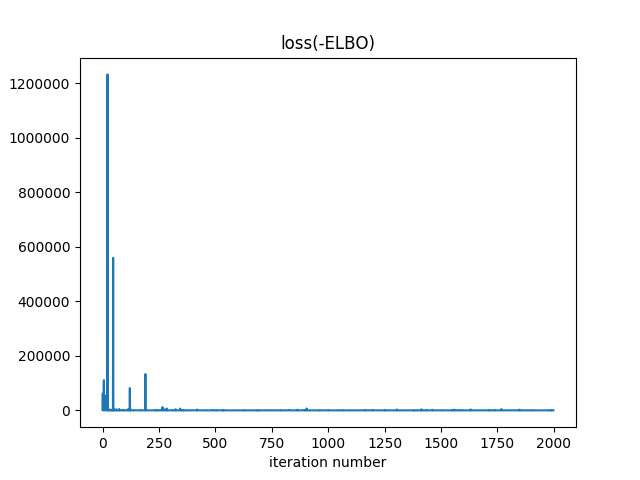

In [7]:
%matplotlib nbagg
plt.title("loss(-ELBO)")
plt.plot(loss)
plt.xlabel("iteration number")
plt.show()
#plt.savefig("loss_ex3.png")

<IPython.core.display.Javascript object>


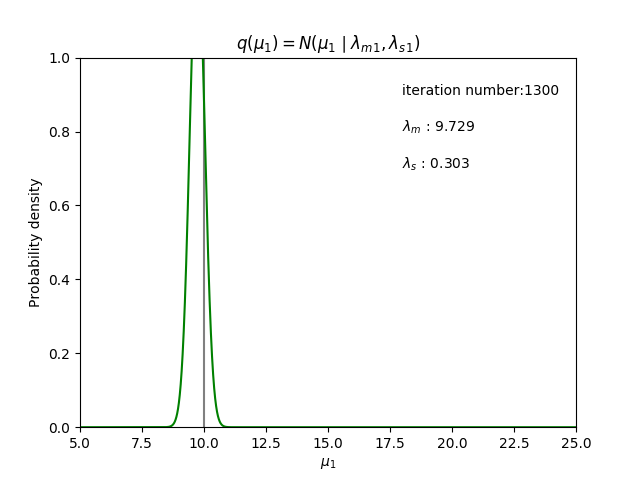

In [12]:
%matplotlib nbagg
grid = np.linspace(start=5.0,stop=25.0,num=10000)
fig = plt.figure()
plt.title("$q(\mu_1)=N(\mu_1\mid{\lambda_m}_1,{\lambda_s}_1)$")
plt.xlabel("$\mu_1$")
plt.ylabel("Probability density")
plt.xlim(5.0,25.0)
plt.ylim(0.0,1.0)
plt.axvline(x=mean_true[0],color="gray")
artists = []
for t,vp in enumerate(variational_parameter):
    if t%10 == 0:
        im = plt.plot(grid,norm.pdf(x=grid,loc=vp[0], scale=vp[1]),color="green")
        text = [plt.text(18,0.9,"iteration number:"+str(t)),
                     plt.text(18,0.8,"$\lambda_m$ : {0:.3f}".format(vp[0])),
                     plt.text(18,0.7,"$\lambda_s$ : {0:.3f}".format(vp[1]))]
        artists.append(im+text)
ani = animation.ArtistAnimation(fig,artists)
plt.show()
#ani.save("mu1_ex3.gif", writer='imagemagick', fps=4)

<IPython.core.display.Javascript object>


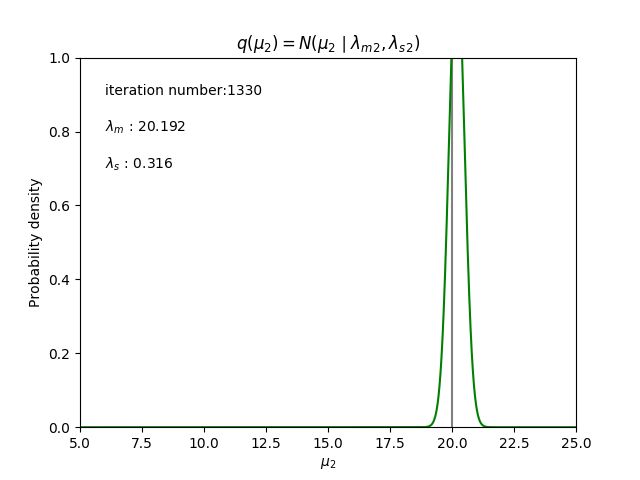

In [13]:
%matplotlib nbagg
grid = np.linspace(start=5.0,stop=25.0,num=10000)
fig = plt.figure()
plt.title("$q(\mu_2)=N(\mu_2\mid{\lambda_m}_2,{\lambda_s}_2)$")
plt.xlabel("$\mu_2$")
plt.ylabel("Probability density")
plt.xlim(5.0,25.0)
plt.ylim(0.0,1.0)
plt.axvline(x=mean_true[1],color="gray")
artists = []
for t,vp in enumerate(variational_parameter):
    if t%10 == 0:
        im = plt.plot(grid,norm.pdf(x=grid,loc=vp[2], scale=vp[3]),color="green")
        text = [plt.text(6,0.9,"iteration number:"+str(t)),
                     plt.text(6,0.8,"$\lambda_m$ : {0:.3f}".format(vp[2])),
                     plt.text(6,0.7,"$\lambda_s$ : {0:.3f}".format(vp[3]))]
        artists.append(im+text)
ani = animation.ArtistAnimation(fig,artists)
plt.show()
#ani.save("mu2_ex3.gif", writer='imagemagick', fps=4)

<IPython.core.display.Javascript object>


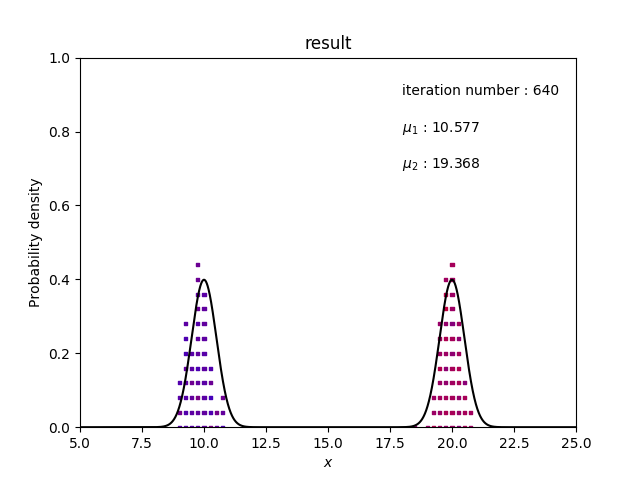

/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/home/tanaka/.pyenv/versions/anaconda3-4.4.0/envs/tfed/lib/python3.5/site-packages/matplotlib/colors.py:251: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


In [27]:
%matplotlib nbagg
grid = np.linspace(start=5.0,stop=25.0,num=10000)
fig = plt.figure()
plt.title("result")
plt.xlabel("$x$")
plt.ylabel("Probability density")
plt.xlim(5.0,25.0)
plt.ylim(0.0,1.0)
plt.plot(grid,norm.pdf(x=grid,loc=mean_true[0], scale=std_true[0])*pi_true[0]+norm.pdf(x=grid,loc=mean_true[1], scale=std_true[1])*pi_true[1],color="black")
area = [[5.0]*N]

artists = []
for t,vp in enumerate(variational_parameter):
    if t%5 == 0:
        #im=plt.plot(grid,norm.pdf(x=grid,loc=vp[0], scale=std_true[0])*pi_true[0]+norm.pdf(x=grid,loc=vp[2], scale=std_true[1])*pi_true[1],
         #        color="green")
        color =[]
        for zn,p in enumerate(vp[4]):
            color.append([p,0.0,1.0-p])
        im_z=plt.scatter(point[0],point[1],s=area,c=color,marker='s')
        text = [plt.text(18,0.9,"iteration number : "+str(t)),
                     plt.text(18,0.8,"$\mu_1$ : {0:.3f}".format(vp[0])),
                     plt.text(18,0.7,"$\mu_2$ : {0:.3f}".format(vp[2]))]
        #artists.append(im+[im_z]+text)
        artists.append([im_z]+text)
ani = animation.ArtistAnimation(fig,artists)
plt.show()
#ani.save("result_ex3.gif", writer='imagemagick', fps=4)